### Cab-Driver Agent

In [1]:
# Importing libraries
import numpy as np
import random
import math
from collections import deque
import collections
import pickle
import os
# for building DQN model
from keras import layers
from keras import Sequential
from keras.layers import Dense, Activation, Flatten
from keras.optimizers import Adam

# for plotting graphs
import matplotlib.pyplot as plt

# Import the environment
#from Env import CabDriver


Using TensorFlow backend.


In [2]:
# Import routines

import numpy as np
import math
import random
from itertools import permutations,product

# Defining hyperparameters
m = 5 # number of cities, ranges from 1 ..... m
t = 24 # number of hours, ranges from 0 .... t-1
d = 7  # number of days, ranges from 0 ... d-1
C = 5 # Per hour fuel and other costs
R = 9 # per hour revenue from a passenger


class CabDriver():

    def __init__(self):
        """initialise your state and define your action space and state space"""
        action_list = list(permutations(range(0,m) ,2))
        action_list.append((0,0))
        self.action_space = np.array(action_list) #action space is unique 2 values(source & destination) + the no op
        self.state_space = list(product(*[list(range(0,m)), list(range(0,t)), list(range(0,d))])) #State space from MDP:
        #𝑠=𝑋𝑖𝑇𝑗𝐷𝑘 𝑤ℎ𝑒𝑟𝑒 𝑖=0…𝑚−1;𝑗=0….𝑡−1;𝑘=0…..𝑑−1, Where 𝑋𝑖 represents a driver’s current location, 𝑇𝑗 represents time component (more specifically hour of the day), 𝐷𝑘 represents the day of the week
        self.state_size = len(self.state_space)
        self.action_size = len(self.action_space)
        self.state_init = random.choice(self.state_space) #Initialises to any random self_space
        self.encode_vector = np.array([24*7, 7, 1]).reshape(3, 1)


        # Start the first round
        self.reset()


    ## Encoding state (or state-action) for NN input

    def state_encod_arch1(self, curr_state, batch_size=1):
        """convert the state into a vector so that it can be fed to the NN. This method converts a given state into a vector format. Hint: The vector is of size m + t + d."""
       
        #Encoded values of m + t + d
        
        curr_state = np.array(curr_state).reshape(1, 3)
        #print(curr_state.shape)
        #enc_mat = self.encode_vector
        # pos = (state[0]*24*7) + (state[1]*7) + state[2]
        
        pos_mat = np.dot(curr_state, self.encode_vector)
        state_encod =  np.zeros((1, self.state_size))
        # state_encod[pos] = 1
        for i in range(batch_size):
            state_encod[i][pos_mat[i]] = 1

        return np.reshape(state_encod, [1, env.state_size])
    


    # Use this function if you are using architecture-2 
    # def state_encod_arch2(self, state, action):
    #     """convert the (state-action) into a vector so that it can be fed to the NN. This method converts a given state-action pair into a vector format. Hint: The vector is of size m + t + d + m + m."""

        
    #     return state_encod


    ## Getting number of requests

    def requests(self, state):
        """Determining the number of requests basis the location. 
        Use the table specified in the MDP and complete for rest of the locations"""
        location = state[0]
        requests = 0
        if location == 0:
            requests = np.random.poisson(2)

        if location == 1:
            requests = np.random.poisson(12)   #MDP Poisson distribution
        
        if location == 2:
            requests = np.random.poisson(4)    #MDP Poisson distribution
            
        if location == 3:
            requests = np.random.poisson(7)    #MDP Poisson distribution

        if location == 4:
            requests = np.random.poisson(8)    #MDP Poisson distribution  
            
        if requests > 15:
            requests = 15

        possible_actions_index = random.sample(range(0, (m-1)*m), requests) # (0,0) is not considered as customer request
        possible_actions_index.append(20) #add the index of No-OP action (0, 0)
        actions = [self.action_space[i] for i in possible_actions_index]

        print('Number of actions available', len(actions))
        return possible_actions_index, actions   



    def reward_func(self, state, action, Time_matrix):
        """Takes in state, action and Time-matrix and returns the reward"""
        if action[0] == action[1]:
            reward = -C 
            return reward

        #print('reward:' ,state, action)
        p = action[0]
        q = action[1]
        i = state[0]
        time = state[1]
        day = state[2]
        #print('reward vals:', (p, q, i, time, day))
        t_pq = Time_matrix[p][q][time][day]
        t_ip = Time_matrix[i][p][time][day]
        
        
        reward = (R*t_pq)-(C*(t_pq+t_ip))
        return reward


    def next_state_func(self, state, action, Time_matrix):
        """Takes state and action as input and returns next state"""
        
        #print('next_state :', state, action)
        p = action[0]
        q = action[1]
        i = state[0]
        time_curr = state[1]
        day_curr = state[2]
        #print('next_state_vals :', (p, q, i, time_curr, day_curr))
        time_next = time_curr + Time_matrix[p][q][time_curr][day_curr]

        day_next = int((day_curr+int(time_next/24)) % 7)
        time_next = int(time_next % 24)
            
        next_state = (q,time_next,day_next)
        return next_state


    def reset(self):
        return self.action_space, self.state_space, self.state_init


#### Defining Time Matrix

In [3]:
# Loading the time matrix provided
Time_matrix = np.load("TM.npy")

#### Tracking the state-action pairs for checking convergence


In [4]:
#Defining a function to save the Q-dictionary as a pickle file
def save_pickle(obj, name ):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

### Agent Class

If you are using this framework, you need to fill the following to complete the following code block:
1. State and Action Size
2. Hyperparameters
3. Create a neural-network model in function 'build_model()'
4. Define epsilon-greedy strategy in function 'get_action()'
5. Complete the function 'append_sample()'. This function appends the recent experience tuple <state, action, reward, new-state> to the memory
6. Complete the 'train_model()' function with following logic:
   - If the memory size is greater than mini-batch size, you randomly sample experiences from memory as per the mini-batch size and do the following:
      - Initialise your input and output batch for training the model
      - Calculate the target Q value for each sample: reward + gamma*max(Q(s'a,))
      - Get Q(s', a) values from the last trained model
      - Update the input batch as your encoded state and output batch as your Q-values
      - Then fit your DQN model using the updated input and output batch.

In [5]:
class DQNAgent:
    def __init__(self, state_size, action_size, discount_factor=0.95, learning_rate=0.01,
                       epsilon=0.99, epsilon_decay=0.99, epsilon_min=0.01):
        # Define size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Write here: Specify you hyper parameters for the DQN
        self.discount_factor = discount_factor
        self.learning_rate = learning_rate        
        self.epsilon_max = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.model_history = None
        
        self.batch_size = 32
        #self.batch_size = 1
        # create replay memory using deque
        self.memory = deque(maxlen=2000)

        # create main model and target model
        self.model = self.build_model()
    

    # approximate Q function using Neural Network
    def build_model(self):
        model = Sequential()
        # Write your code here: Add layers to your neural nets       

        # hidden layers
        model.add(Dense(32, input_dim=self.state_size, activation='relu', kernel_initializer='he_uniform'))
        model.add(Dense(32, activation='relu', kernel_initializer='he_uniform'))

        # the output layer: output is of size num_actions
        model.add(Dense(self.action_size, activation='relu', kernel_initializer='he_uniform'))     
        model.compile(loss='mse',optimizer=Adam(lr=self.learning_rate))
        model.summary()
        return model


    def get_action(self, cstate, all_actions, pos_act_ind):
    # Write your code here:
    # get action from model using epsilon-greedy policy
    # Decay in ε after we generate each sample from the environment
        actions = all_actions[pos_act_ind]
        if np.random.rand() <= self.epsilon_max:
            # explore: choose a random action from all possible actions
            print('Exploring')
            action = random.choice(actions)
        else:
            # choose the action with the highest q(s, a)
            # the first index corresponds to the batch size, so
            # reshape state to (1, state_size) so that the first index corresponds to the batch size
            print('Exploiting')
            cstate = cstate.reshape(1, self.state_size) 
            q_value = self.model.predict(x=cstate)
            max_index = np.argmax(q_value[0])
            action = all_actions[max_index] if max_index in pos_act_ind else random.choice(actions)
        print('Selected action ', action)    
        return action
        

    def append_sample(self, state, action, reward, next_state, done):
    # Write your code here:
    # save sample <s,a,r,s'> to the replay memory
        self.memory.append((state, action, reward, next_state, done))
    
    
    # pick samples randomly from replay memory (with batch_size) and train the network
    def train_model(self):
        if len(self.memory) > self.batch_size:
            # Sample batch from the memory
            mini_batch = random.sample(self.memory, self.batch_size)
            update_input = np.zeros((self.batch_size, self.state_size))
            update_output = np.zeros((self.batch_size, self.state_size))
            
            actions, rewards, done = [], [], []
            
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                
                # Write your code from here
                # 1. Predict the target from earlier model
                update_input[i] = env.state_encod_arch1(state)
                actions.append(action)
                rewards.append(reward)
                update_output[i] = env.state_encod_arch1(next_state)
                done.append(done_boolean)
                
            # 2. Get the target for the Q-network
            
            target = self.model.predict(update_input)
            target_qval = self.model.predict(update_output)
            #print(target, target.shape)
            #print(target.shape, target_qval.shape)

            #3. Update your 'update_output' and 'update_input' batch
            for i in range(self.batch_size):
                #print(i, actions[i])
                if done[i]:
                    #target[i][actions[i]] = rewards[i]
                    target[i] = rewards[i]
                else: # non-terminal state
                    #target[i][actions[i]] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                    target[i] = rewards[i] + self.discount_factor * np.max(target_qval[i])
                
        # 4. Fit your model and track the loss values
            return self.model.fit(update_input, target, batch_size=self.batch_size, epochs=1, verbose=1)
            
            
    def save(self, name):
        self.model.save(name)

In [6]:
# to store rewards in each episode
rewards_per_episode, episodes = [], []

# make dir to store model weights
if not os.path.exists("saved_model_weights"):
    os.mkdir("saved_model_weights")

# n_episodes
n_episodes = 5

### DQN block

In [7]:
 # Call all the initialised variables of the environment
env = CabDriver()
#Call the DQN agent
dqn = DQNAgent(env.state_size, env.action_size)

for episode in range(n_episodes):

    # Write code here
    # Call the environment
   
    _,_,curr_state = env.reset()
    state_size = env.state_size
    pos_act_ind, actions = env.requests(curr_state)
    action = random.choice(actions)
    #action_size = len(actions)
    reward = 0
    curr_time = 0
    #print(curr_state)
    
    
    terminal_state = False
    print("Episode :", episode)
    
    while not terminal_state:
        # Write your code here
        # 1. Pick epsilon-greedy action from possible actions for the current state
        encoded_state = env.state_encod_arch1(curr_state)
        #encoded_state = np.reshape(encoded_state, [1, env.state_size])
        action = dqn.get_action(encoded_state, env.action_space, pos_act_ind)
        # 2. Evaluate your reward and next state
        reward = reward + env.reward_func(curr_state, action, Time_matrix)
        next_state = env.next_state_func(curr_state,action,Time_matrix)
        
        p = action[0]
        q = action[1]
        i = curr_state[0]
        time = curr_state[1]
        day = curr_state[2]
        print(action)
        curr_time = curr_time + Time_matrix[i][p][time][day]
        
        
        day = int((day+int(time/24)) % 7)
        time = int(time % 24)
        
        curr_time = curr_time + Time_matrix[p][q][time][day]
        day = int((day+int(time/24)) % 7)
        time = int(time % 24)
        # 3. Append the experience to the memory
        dqn.append_sample(curr_state, action, reward, next_state, terminal_state)
        curr_state = next_state
        
        # 4. Train the model by calling function agent.train_model
        history = dqn.train_model()
        # 5. Keep a track of rewards, Q-values, loss
        
        #if history:
         #   print('rewards: ', reward, 'q-value: ', action)
         #   print('loss:', history.history['loss'])
        
        if curr_time >= 24*30:
            terminal_state = True
    
        # store total reward obtained in this episode
    rewards_per_episode.append(reward)
    episodes.append(episode)
        
    if dqn.epsilon_max > dqn.epsilon_min:
        dqn.epsilon_max *= dqn.epsilon_decay        
        
        

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                26912     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 21)                693       
Total params: 28,661
Trainable params: 28,661
Non-trainable params: 0
_________________________________________________________________
Number of actions available 7
Episode : 0
Exploring
Selected action  [3 4]
[3 4]
Exploring
Selected action  [0 1]
[0 1]
Exploring
Selected action  [0 1]
[0 1]
Exploring
Selected action  [0 2]
[0 2]
Exploring
Selected action  [3 4]
[3 4]
Exploring
Selected action  [0 2]
[0 2]
Exploring
Selected action  [3 4]
[3 4]
Exploring
Selected action  [0 0]
[0 0]
Exploring
Selected action  [3 0]
[3 0]
Exploring

Exploring
Selected action  [3 2]
[3 2]
Epoch 1/1
32/32 [==============================] - 0s 50us/step - loss: 12735.9297
Exploring
Selected action  [3 4]
[3 4]
Epoch 1/1
32/32 [==============================] - 0s 42us/step - loss: 14275.6045
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 47us/step - loss: 15198.1699
Exploring
Selected action  [3 0]
[3 0]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 14969.0381
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 39us/step - loss: 18284.8594
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 46us/step - loss: 20610.4121
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 38us/step - loss: 20707.7441
Exploring
Selected action  [3 0]
[3 0]
Epoch 1/1
32/32 [==============================] - 0s 37us/step - loss: 27845.1680
Exploring
Selected actio

Exploring
Selected action  [1 4]
[1 4]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 56159.1016
Exploring
Selected action  [4 0]
[4 0]
Epoch 1/1
32/32 [==============================] - 0s 39us/step - loss: 59457.4023
Exploring
Selected action  [1 4]
[1 4]
Epoch 1/1
32/32 [==============================] - 0s 42us/step - loss: 60036.6875
Exploring
Selected action  [1 0]
[1 0]
Epoch 1/1
32/32 [==============================] - 0s 40us/step - loss: 52954.1602
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 47us/step - loss: 49367.3281
Exploring
Selected action  [3 0]
[3 0]
Epoch 1/1
32/32 [==============================] - 0s 47us/step - loss: 52821.4297
Exploring
Selected action  [3 1]
[3 1]
Epoch 1/1
32/32 [==============================] - 0s 44us/step - loss: 60295.8555
Exploring
Selected action  [3 1]
[3 1]
Epoch 1/1
32/32 [==============================] - 0s 46us/step - loss: 64726.9844
Exploring
Selected actio

Epoch 1/1
32/32 [==============================] - 0s 42us/step - loss: 28843.6836
Exploring
Selected action  [3 0]
[3 0]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 24567.2773
Exploring
Selected action  [2 0]
[2 0]
Epoch 1/1
32/32 [==============================] - 0s 42us/step - loss: 25067.2832
Exploring
Selected action  [1 0]
[1 0]
Epoch 1/1
32/32 [==============================] - 0s 46us/step - loss: 22562.8945
Exploring
Selected action  [3 0]
[3 0]
Epoch 1/1
32/32 [==============================] - 0s 43us/step - loss: 27156.4180
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 40us/step - loss: 27082.0098
Exploring
Selected action  [3 1]
[3 1]
Epoch 1/1
32/32 [==============================] - 0s 44us/step - loss: 27057.3125
Exploring
Selected action  [1 2]
[1 2]
Epoch 1/1
32/32 [==============================] - 0s 55us/step - loss: 25583.4883
Exploring
Selected action  [3 1]
[3 1]
Epoch 1/1
32/32 [=======

Epoch 1/1
32/32 [==============================] - 0s 46us/step - loss: 15864.7559
Exploring
Selected action  [0 3]
[0 3]
Epoch 1/1
32/32 [==============================] - 0s 43us/step - loss: 22933.8047
Exploring
Selected action  [0 4]
[0 4]
Epoch 1/1
32/32 [==============================] - 0s 57us/step - loss: 26840.6348
Exploring
Selected action  [1 0]
[1 0]
Epoch 1/1
32/32 [==============================] - 0s 47us/step - loss: 28182.5508
Exploring
Selected action  [3 0]
[3 0]
Epoch 1/1
32/32 [==============================] - 0s 51us/step - loss: 24088.2871
Exploring
Selected action  [1 0]
[1 0]
Epoch 1/1
32/32 [==============================] - 0s 52us/step - loss: 28601.7734
Exploring
Selected action  [0 3]
[0 3]
Epoch 1/1
32/32 [==============================] - 0s 48us/step - loss: 24293.6445
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 48us/step - loss: 23530.4492
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [=======

Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 51us/step - loss: 72658.6172
Exploring
Selected action  [1 0]
[1 0]
Epoch 1/1
32/32 [==============================] - 0s 41us/step - loss: 45467.1094
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 53us/step - loss: 61141.9648
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 45233.0742
Exploring
Selected action  [0 4]
[0 4]
Epoch 1/1
32/32 [==============================] - 0s 38us/step - loss: 76594.7031
Exploring
Selected action  [0 4]
[0 4]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 79161.2812
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 41us/step - loss: 56160.6562
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 40us/step - loss: 51652.8516
Exploring
Selected actio

Exploring
Selected action  [4 3]
[4 3]
Epoch 1/1
32/32 [==============================] - 0s 42us/step - loss: 122238.8906
Exploiting
Selected action  [4 1]
[4 1]
Epoch 1/1
32/32 [==============================] - 0s 39us/step - loss: 89605.5000
Exploring
Selected action  [4 3]
[4 3]
Epoch 1/1
32/32 [==============================] - 0s 44us/step - loss: 114449.7891
Exploring
Selected action  [0 1]
[0 1]
Epoch 1/1
32/32 [==============================] - 0s 61us/step - loss: 147923.4375
Exploring
Selected action  [4 1]
[4 1]
Epoch 1/1
32/32 [==============================] - 0s 44us/step - loss: 133283.4844
Exploring
Selected action  [1 3]
[1 3]
Epoch 1/1
32/32 [==============================] - 0s 41us/step - loss: 148634.6406
Exploring
Selected action  [4 3]
[4 3]
Epoch 1/1
32/32 [==============================] - 0s 41us/step - loss: 135358.9375
Exploring
Selected action  [2 0]
[2 0]
Epoch 1/1
32/32 [==============================] - 0s 39us/step - loss: 145102.2812
Exploring
Select

Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 48us/step - loss: 49204.8125
Exploring
Selected action  [2 1]
[2 1]
Epoch 1/1
32/32 [==============================] - 0s 53us/step - loss: 70949.6562
Exploring
Selected action  [0 0]
[0 0]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 80200.1016
Exploring
Selected action  [4 0]
[4 0]
Epoch 1/1
32/32 [==============================] - 0s 58us/step - loss: 39148.6367
Exploring
Selected action  [0 4]
[0 4]
Epoch 1/1
32/32 [==============================] - 0s 49us/step - loss: 70335.1094
Exploring
Selected action  [1 2]
[1 2]
Epoch 1/1
32/32 [==============================] - 0s 43us/step - loss: 69124.2656
Exploiting
Selected action  [0 4]
[0 4]
Epoch 1/1
32/32 [==============================] - 0s 48us/step - loss: 49247.5469
Exploring
Selected action  [1 2]
[1 2]
Epoch 1/1
32/32 [==============================] - 0s 49us/step - loss: 70784.5938
Exploring
Selected acti

Epoch 1/1
32/32 [==============================] - 0s 49us/step - loss: 90885.4375
Exploring
Selected action  [3 2]
[3 2]
Epoch 1/1
32/32 [==============================] - 0s 39us/step - loss: 56581.4531
Exploring
Selected action  [3 2]
[3 2]
Epoch 1/1
32/32 [==============================] - 0s 50us/step - loss: 47469.0547
Exploring
Selected action  [2 1]
[2 1]
Epoch 1/1
32/32 [==============================] - 0s 46us/step - loss: 41269.5391
Exploring
Selected action  [2 1]
[2 1]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 76415.0078
Exploring
Selected action  [3 2]
[3 2]
Epoch 1/1
32/32 [==============================] - 0s 43us/step - loss: 86359.5156
Exploring
Selected action  [1 2]
[1 2]
Epoch 1/1
32/32 [==============================] - 0s 43us/step - loss: 91162.7344
Exploring
Selected action  [1 2]
[1 2]
Epoch 1/1
32/32 [==============================] - 0s 45us/step - loss: 72908.8438
Exploring
Selected action  [3 2]
[3 2]
Epoch 1/1
32/32 [=======

Average reward of last 100 episodes is 46.4


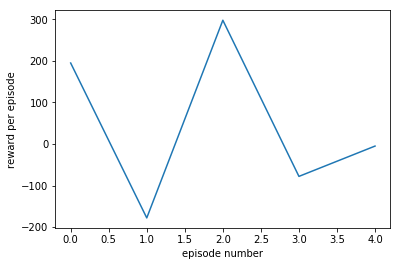

In [8]:
# make directory
if not os.path.exists("saved_pickle_files"):
    os.mkdir("saved_pickle_files")

# save rewards_per_episode
save_pickle(rewards_per_episode, "saved_pickle_files/rewards_per_episode")


# plot results
with open('saved_pickle_files/rewards_per_episode.pkl', 'rb') as f:
    rewards_per_episode = pickle.load(f)

plt.plot(list(range(len(rewards_per_episode))), rewards_per_episode)
plt.xlabel("episode number")
plt.ylabel("reward per episode")

# save plots in saved_plots/ directory
plt.savefig('rewards.png')

print("Average reward of last 100 episodes is {0}".format(np.mean(rewards_per_episode[-100:])))

### Tracking Convergence

#### Epsilon-decay sample function

<div class="alert alert-block alert-info">
Try building a similar epsilon-decay function for your model.
</div>

In [9]:
time = np.arange(0,10000)
epsilon = []
for i in range(0,10000):
    epsilon.append(0 + (1 - 0) * np.exp(-0.0009*i))

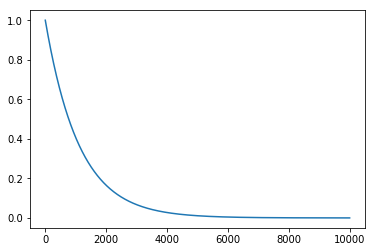

In [10]:
plt.plot(time, epsilon)
plt.show()